In [1]:
from collections import defaultdict
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys; sys.path.append("models")
from config import get_case_config, get_case_sensitivities
import sensitivity, utils
from strategies import RETURN_KEYS

from chart_books import *

In [2]:
def config_files(folder):
    return filter(lambda x: x.startswith("config") and x.endswith('.json'), os.listdir(folder))

def run_fname(cfg_fname):
    return cfg_fname.replace("config", "run").replace("json", 'csv')

def resgen(data_dir):
    lockdowns = next(os.walk(data_dir))[1]
    for lockdown in lockdowns:
        folder = os.path.join(data_dir, lockdown)
        for cfg_file in config_files(folder):
            cfg = utils.read_json(os.path.join(folder, cfg_file))
            target = cfg[sensitivity.TARGET_KEY]
            results = pd.read_csv(os.path.join(folder, run_fname(cfg_file)), index_col=0)
            yield lockdown, target, cfg[sensitivity.CONFIG_KEY], results

In [3]:
import utils
import config
keys_to_plot = [RETURN_KEYS.reduced_r, RETURN_KEYS.tests]
rc_dct = {
    'figure.figsize': (14, 6),
    'figure.max_open_warning': 1000,
    "errorbar.capsize": 2.5,
#     "errorbar.capwidth": 2.5
}
chart_folder = os.path.join(os.environ['REPOS'], 'tti-explorer', 'charts')
input_folder = os.path.join(os.environ['DATA'], "tti-explorer", "new_results")

# Pinch Points

In [4]:
pinch_points_dir = os.path.join(input_folder, "pinch-points")
pinch_points_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for lockdown, target, cfg, results in resgen(pinch_points_dir):
    if target in ['testing_delay', 'manual_trace_delay']:
        continue
    if int(lockdown[1]) > 0:
        level, measures = lockdown.split('_', maxsplit=1)
        pinch_points_results[level][target][measures].append((cfg[target], results))

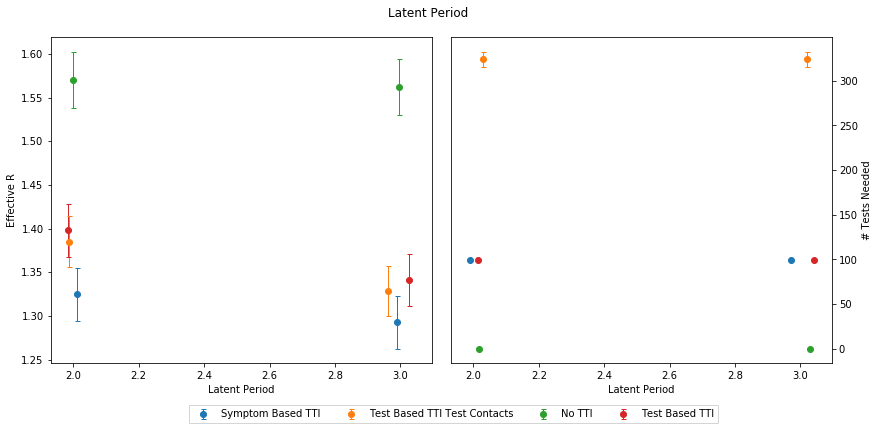

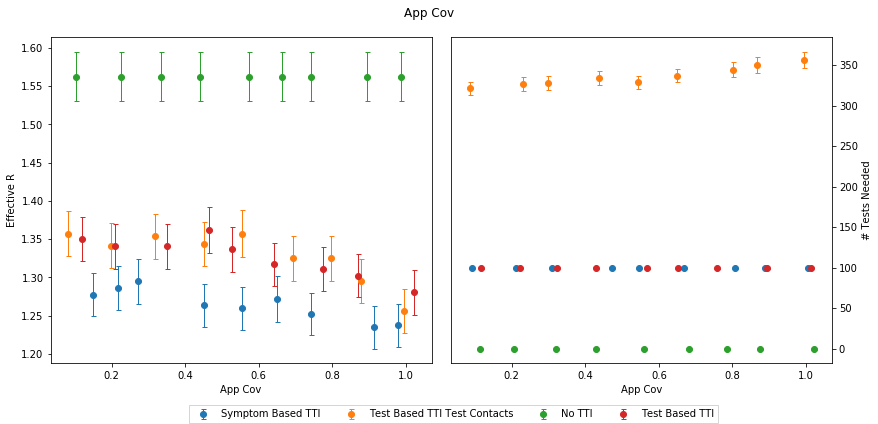

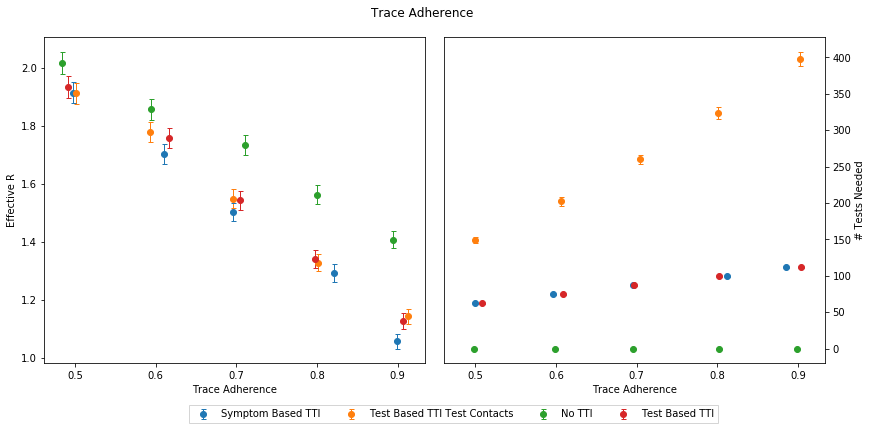

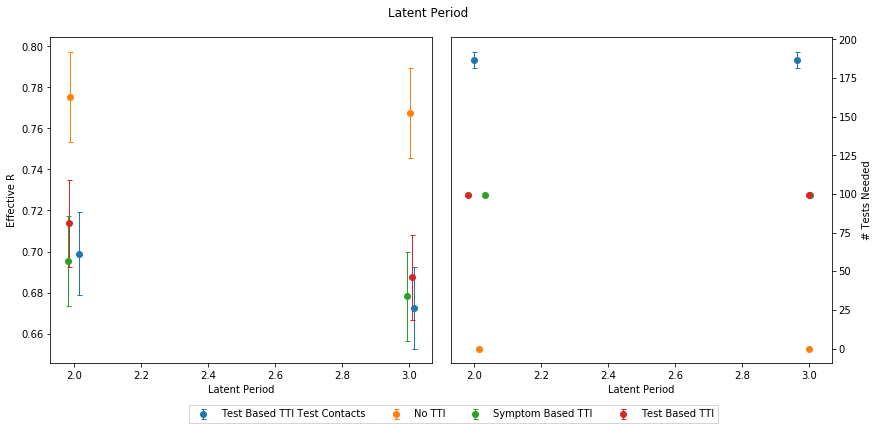

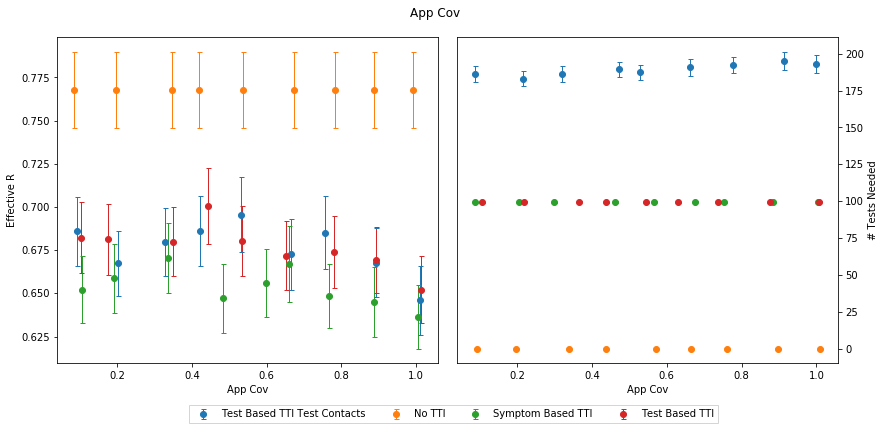

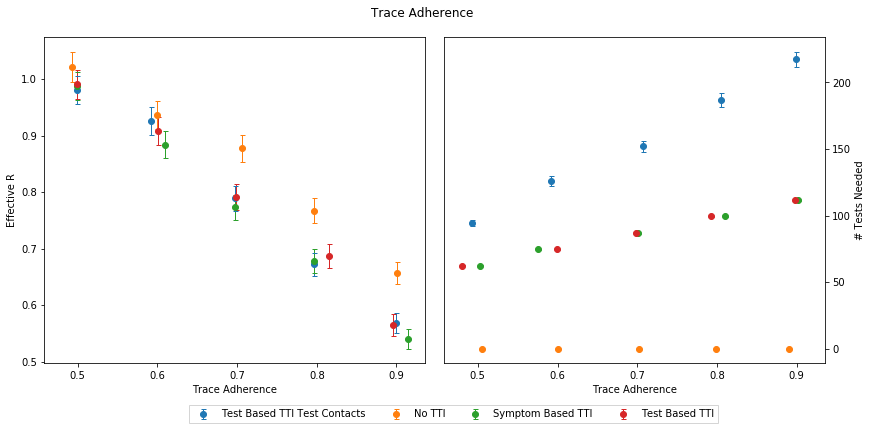

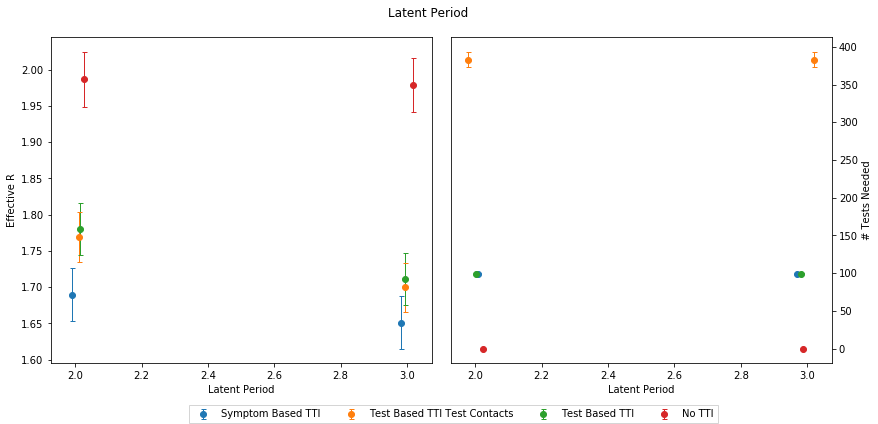

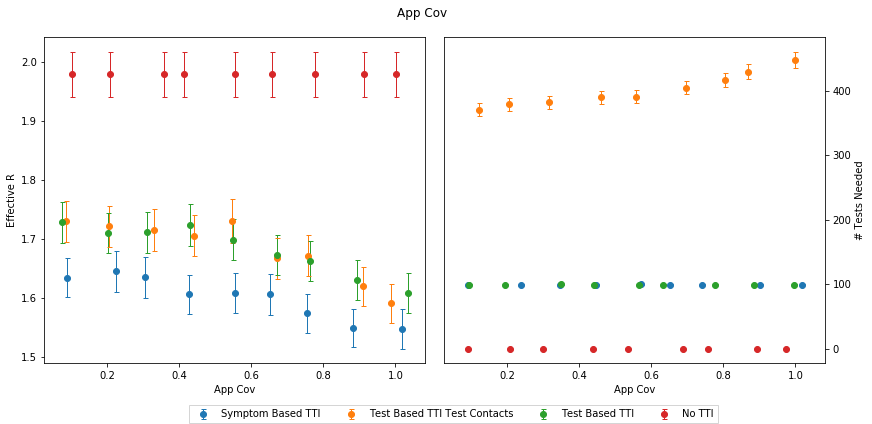

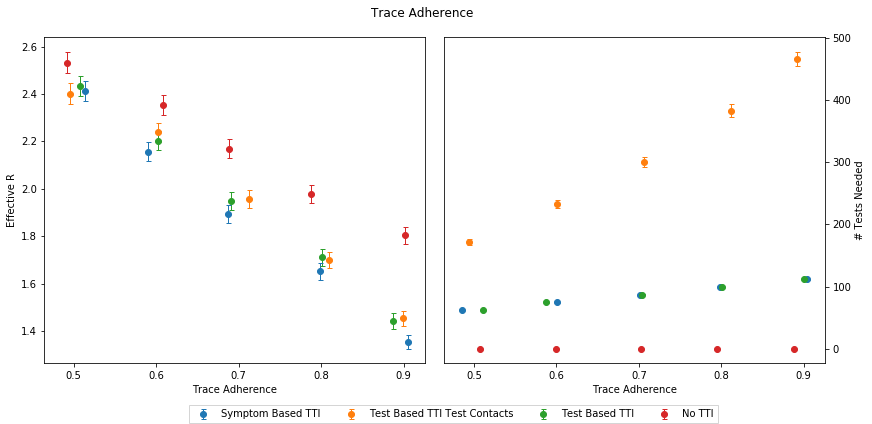

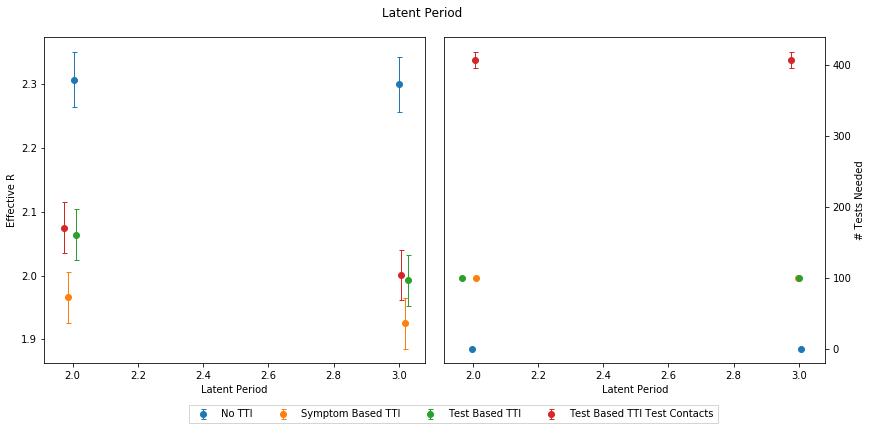

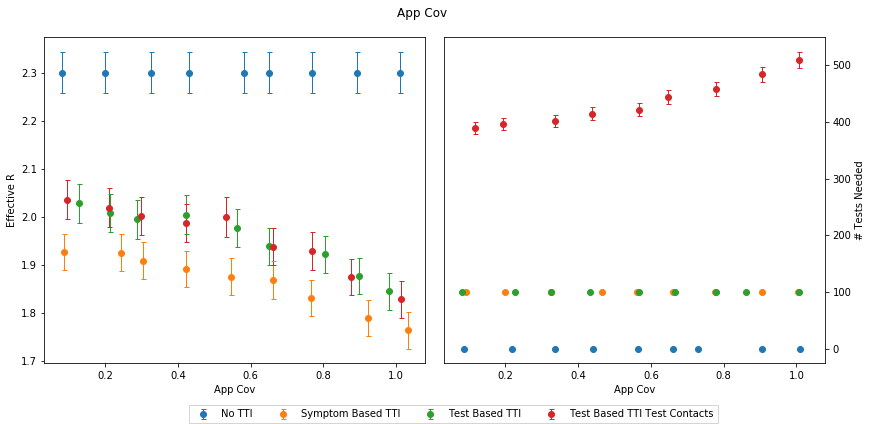

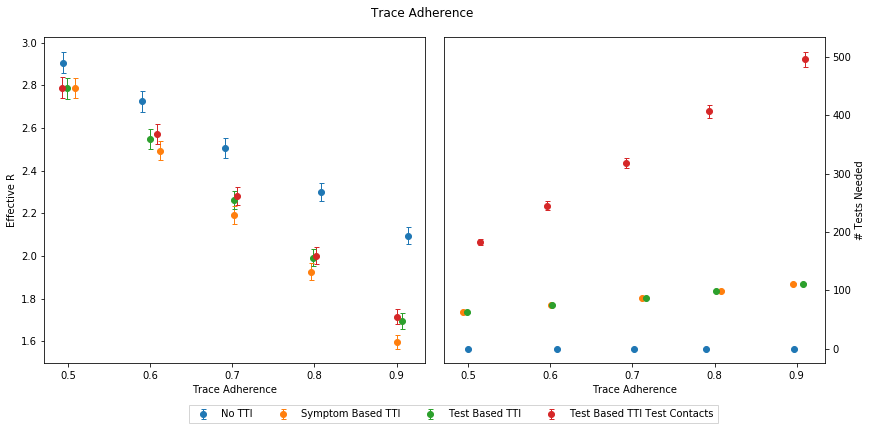

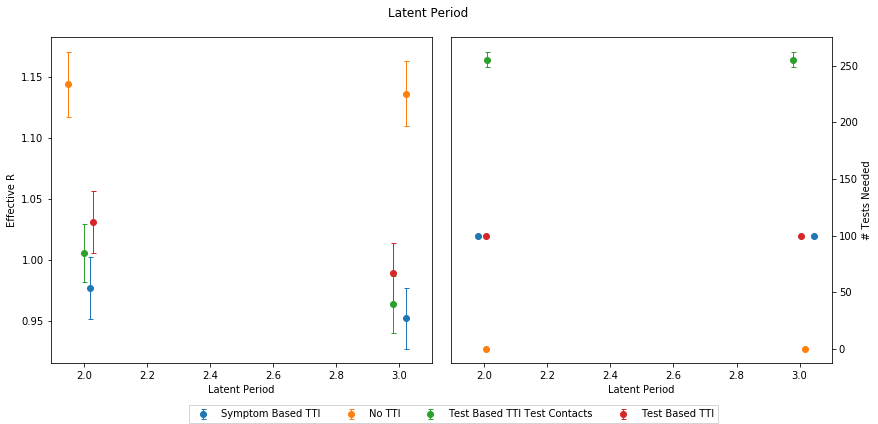

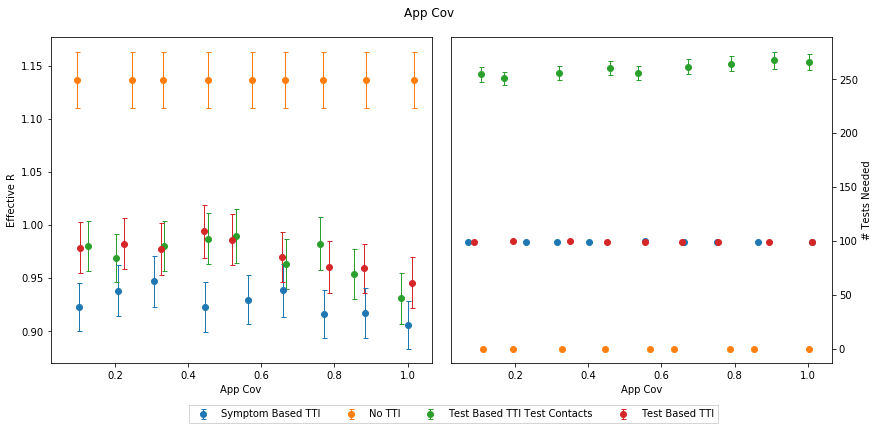

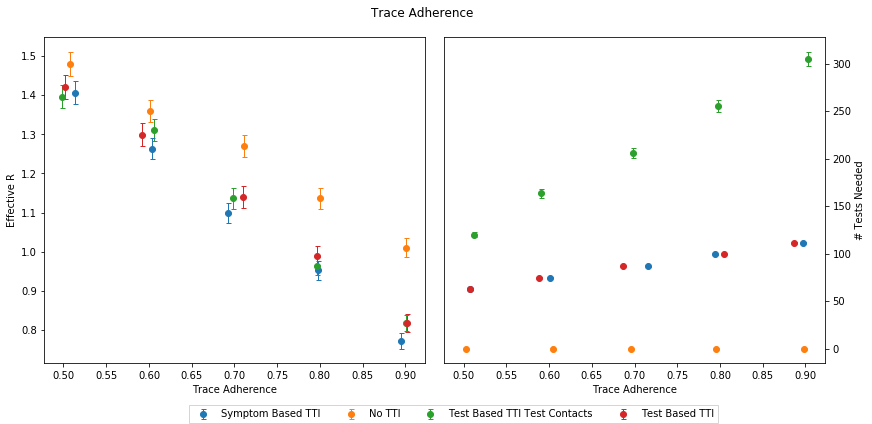

In [5]:
with plt.rc_context(rc_dct):
    for level, results in pinch_points_results.items():
        deck = utils.PdfDeck()
        plot_lockdown(results, deck, keys_to_plot)
        deck.make(os.path.join(chart_folder, f"{level}_pinch_points.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)

# Test Trace Tables

In [6]:
tt_dir = os.path.join(input_folder, "pinch-points-test-trace-delay")
test_trace_results = defaultdict(lambda: defaultdict(list))
for lockdown, target, cfg, results in resgen(tt_dir):
    if int(lockdown[1]) > 0:
        vals = [cfg[k] for k in target]
        level, measures = lockdown.split('_', maxsplit=1)
        results = results.set_index(config.STATISTIC_COLNAME, drop=True)[keys_to_plot]
        test_trace_results[level][measures].append((vals, results))  

In [7]:
def make_tables(entry, key=RETURN_KEYS.reduced_r):
    coords, reslist = zip(*entry)
    means, stds = zip(*[(k[key]['mean'], k[key]['std']) for k in reslist])
    means_mat = pd.DataFrame(np.array(utils.sort_by(means, coords, return_idx=False)).reshape(3, 3))
    stds_mat = pd.DataFrame(np.array(utils.sort_by(stds, coords, return_idx=False)).reshape(3, 3))
    return means_mat, stds_mat


def format_table(means, stds):
    t1, t2 = ['Test Delay (days)', 'Manual Trace Delay (days)']

    table = means.applymap(
            lambda x: f"{x:.2f}"
        ).add(
            " \pm "
        ).add(
            stds.mul(
                1.96 
            ).applymap(
                lambda x: f"{x:.2f}"
            )
        ).applymap(lambda x: f"${x}$")
    
    table.index =  range(1, 4)
    table.columns = range(1, 4)
    table.index.name = t1
    table.columns.name = t2
    return table

In [8]:
table_deck = utils.LatexTableDeck()

for k in sorted(test_trace_results.keys()):
    table_deck.add_section(f"Lockdown Level {k}")
    for policy, entry in test_trace_results[k].items():
        means, stds = make_tables(entry, key=RETURN_KEYS.reduced_r)
        table = format_table(means, stds)
        table_deck.add_table(
            tex_table=table.to_latex(escape=False),
            caption=nice_lockdown_name(policy)
        )
    table_deck.clearpage()
table_deck.make("test-trace-tables.tex")

In [9]:
# two charts for covid and flue like
# do num tests and num contact tracings needed for infection proportions

# Sensitivity

In [10]:
case_sensitivity_results = defaultdict(dict)
case_sensitivity_dir = os.path.join(input_folder, 'case-sensitivity')
for lockdown, target, cfg, results in resgen(case_sensitivity_dir):
    if lockdown[1] == '0': 
        continue
    level, measures = lockdown.split("_", maxsplit=1)
    case_sensitivity_results[level][measures] = pd.read_csv(
        os.path.join(case_sensitivity_dir, lockdown, "run_0.csv"),
        index_col=0
    )

In [11]:
import config

class LockdownSensitivityPlotter:
    def __init__(self):
        vary_flu = [f"{k}k" for k in [50, 100, 200, 300]]
        vary_covid = [f"{k}k" for k in [10, 20, 30]]
        #[ 
#         (
#             f"{k}k SC-\n"
#             f"{round(config.PROP_COVID_SYMPTOMATIC * 20)}k SC+\n"
#             f"{round((1 - config.PROP_COVID_SYMPTOMATIC) * 20)}k AC+\n"
#         )
#             for k in [50, 100, 200, 300]
#         ]


#             (
#                 f"{100}k SC-\n"
#                 f"{round(config.PROP_COVID_SYMPTOMATIC * k)}k SC+\n"
#                 f"{round((1 - config.PROP_COVID_SYMPTOMATIC) * k)}k AC+\n"
#             )
#                 for k in [10, 20, 30]
#             ]

        inf_props_ticklabels = vary_flu
        inf_props_ticklabels.extend(vary_covid)
        inf_props_ticklabels.append(
            (f"100k SC-\n"
             f"{round(config.PROP_COVID_SYMPTOMATIC * 20)}k SC+\n"
             f"{round((1 - config.PROP_COVID_SYMPTOMATIC) * 20)}k AC+\n")
        )
        self.ticklabel_maps = {
            'inf_profile': np.array(["Earlier", "Moderate", "Later"]),
             'infection_proportions': np.array(inf_props_ticklabels),
             'p_day_noticed_symptoms': np.array(["Earlier", "Moderate", "Later"])[::-1],
        }
        self. param_map = {
                'oxteam_inf_profile11_seed0': 0,
                 'oxteam_inf_profile12_seed0': 1,
                 'oxteam_inf_profile13_seed0': 2,
                 'oxteam_infection_proportions0_seed0': 0,
                 'oxteam_infection_proportions1_seed0': 1,
                 'oxteam_infection_proportions2_seed0': 2,
                 'oxteam_infection_proportions3_seed0': 3,
                 'oxteam_infection_proportions4_seed0': 4,
                 'oxteam_infection_proportions5_seed0': 5,
                 'oxteam_infection_proportions6_seed0': 6,
                 'oxteam_infection_proportions7_seed0': 7,
                 'oxteam_p_day_noticed_symptoms10_seed0': 2,
                 'oxteam_p_day_noticed_symptoms8_seed0': 0,
                 'oxteam_p_day_noticed_symptoms9_seed0': 1
            }
    def grouper(self, s):  ## hack!
        l = s.split("_")[1:-1]
        string = "_".join(l)
        for i in range(10):
            string = string.replace(f"{i}", "")
        return string
        
    def __call__(self, results, deck, keys_to_plot):
        by_param = pd.concat(results, axis=0).groupby(level=1, by=self.grouper)
        for param_name, v in by_param:
            if param_name == "infection_proportions":
                continue
#                 self.plot_infection_proportions(v, deck, keys_to_plot)
            fig, axarr = plt.subplots(1, 2)
            for key, ax in zip(keys_to_plot, axarr.flat):
                for measure, dfstats in v[[key, config.STATISTIC_COLNAME]].groupby(level=0):
                    dfstats = dfstats.droplevel(0).rename(self.param_map)
                    mean = dfstats.query(
                        f"{config.STATISTIC_COLNAME}=='mean'"
                    ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
                    std = dfstats.query(
                        f"{config.STATISTIC_COLNAME}=='std'"
                    ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
                    xaxis = mean.index.values
                    errorbar(ax, xaxis, mean.values, std.values, label=nice_lockdown_name(measure))
                    #errorbar
                    ax.set_xticks(xaxis)
                    ax.set_xticklabels(self.ticklabel_maps[param_name][xaxis])
                ax.set_xlabel(nice_param_name(param_name), x=0)
                ax.set_ylabel(key)
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.set_xlabel("")
            plt.subplots_adjust(wspace=0.05)
            legend(fig, ax)
            deck.add_figure(fig, name=param_name)
            

In [12]:
def plot_infection_props(self, results, deck):
    keys_to_plot = [RETURN_KEYS.tests, RETURN_KEYS.man_trace]
    for slc, name in zip([slice(0, 3), slice(4, 7)],
                         ["# Symptomatic", "# COVID positive"]):
        by_param = pd.concat(results, axis=0).groupby(level=1, by=self.grouper)
        for param_name, v in by_param:
            if param_name != "infection_proportions":
                continue
            fig, axarr = plt.subplots(1, 2)
            for key, ax in zip(keys_to_plot, axarr.flat):
                for measure, dfstats in v[[key, config.STATISTIC_COLNAME]].groupby(level=0):
                    dfstats = dfstats.droplevel(0).rename(self.param_map)
                    mean = dfstats.query(
                        f"{config.STATISTIC_COLNAME}=='mean'"
                    ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
                    std = dfstats.query(
                        f"{config.STATISTIC_COLNAME}=='std'"
                    ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
                    xaxis = mean.index.values
                    errorbar(ax, xaxis[slc], mean.values[slc], std.values[slc], label=nice_lockdown_name(measure))
                    ax.set_xticks(xaxis[slc])
                    ax.set_xticklabels(self.ticklabel_maps[param_name][xaxis[slc]])
                ax.set_xlabel(name, x=0)
                ax.set_ylabel(key)
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.set_xlabel("")
            plt.subplots_adjust(wspace=0.05)
            legend(fig, ax)
        deck.add_figure(fig, name=param_name)

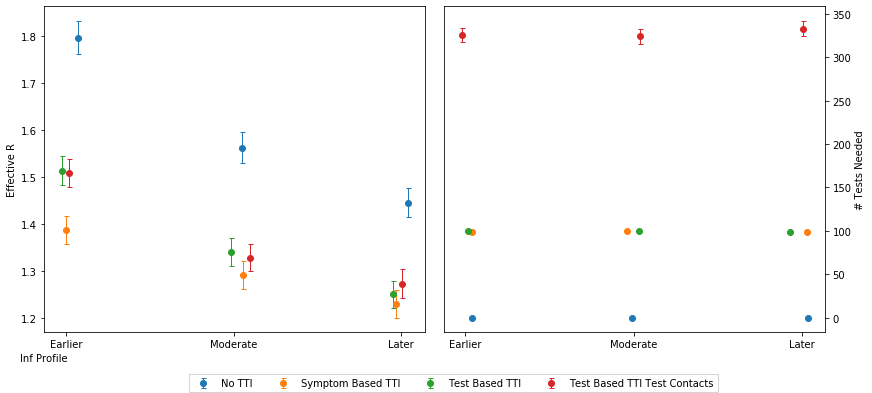

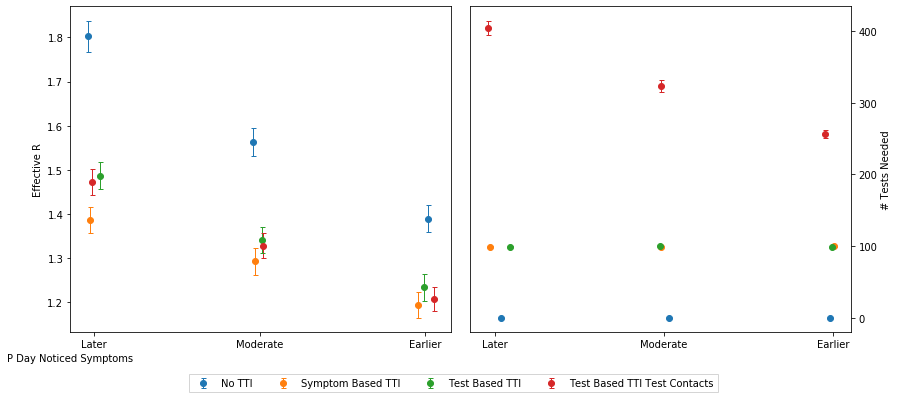

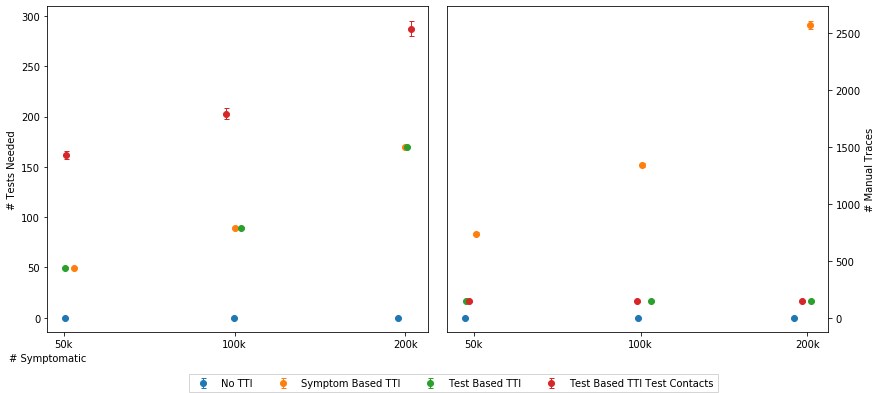

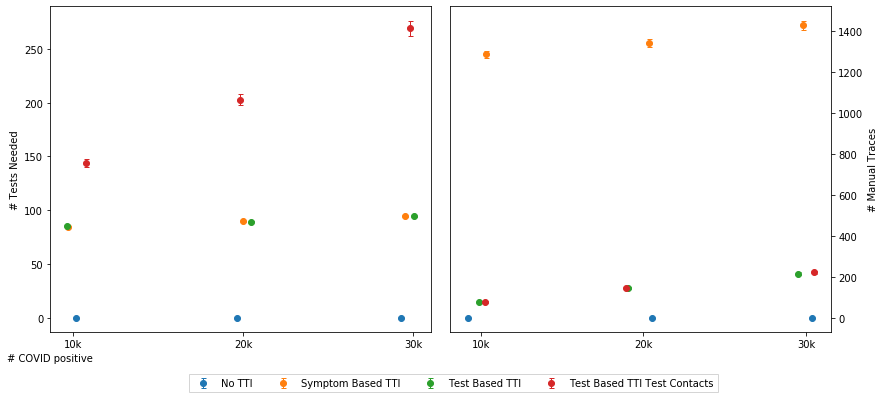

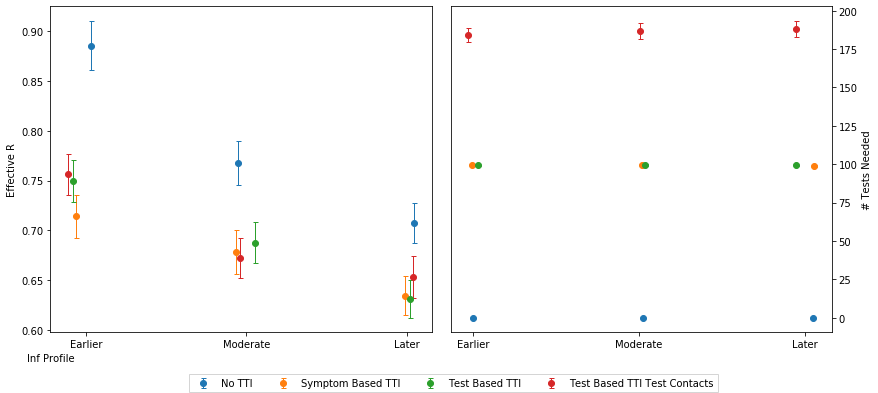

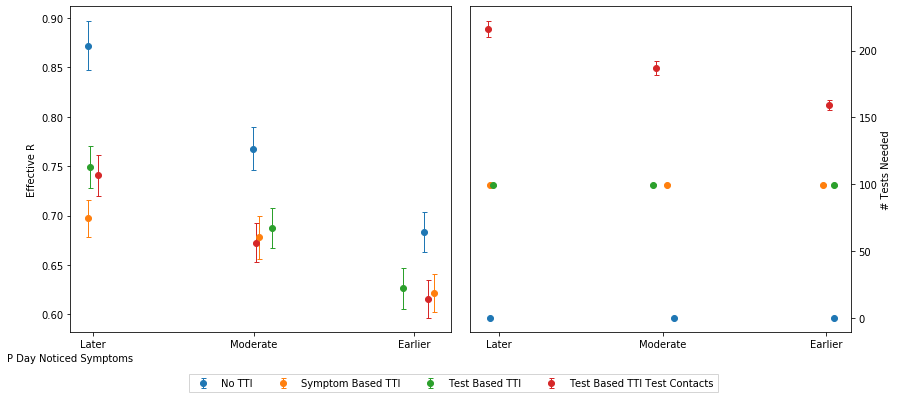

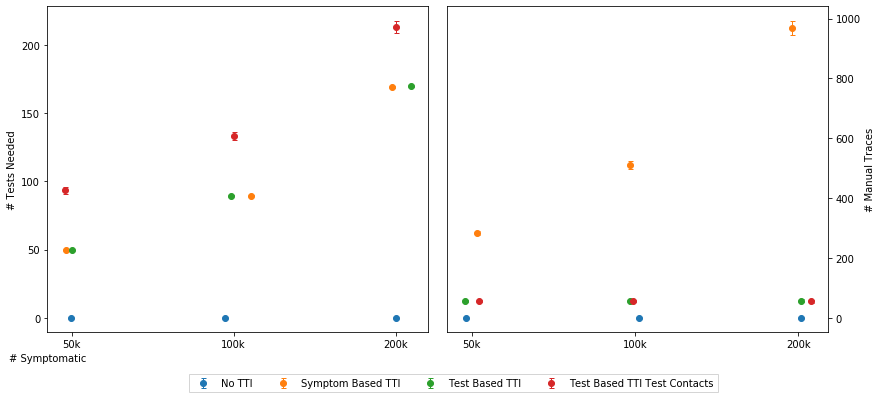

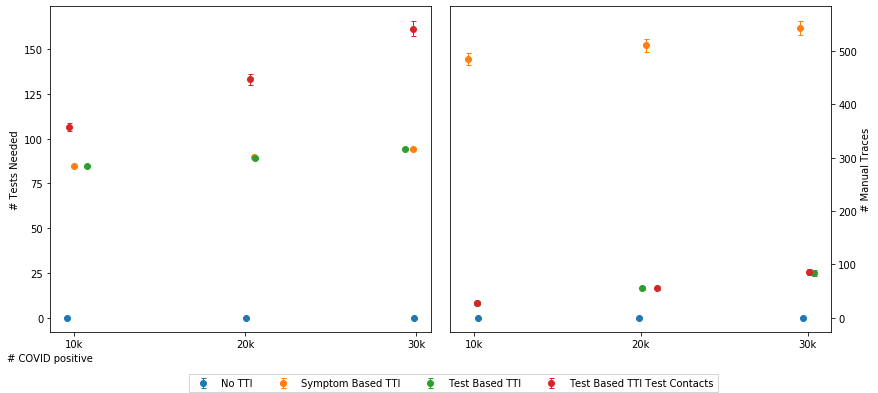

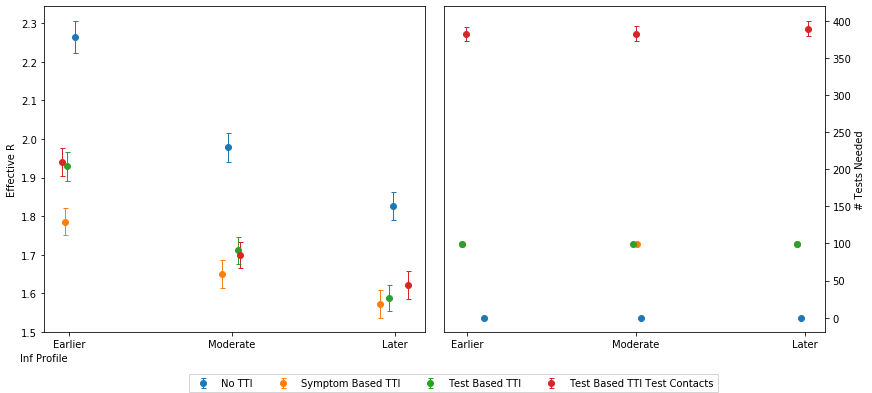

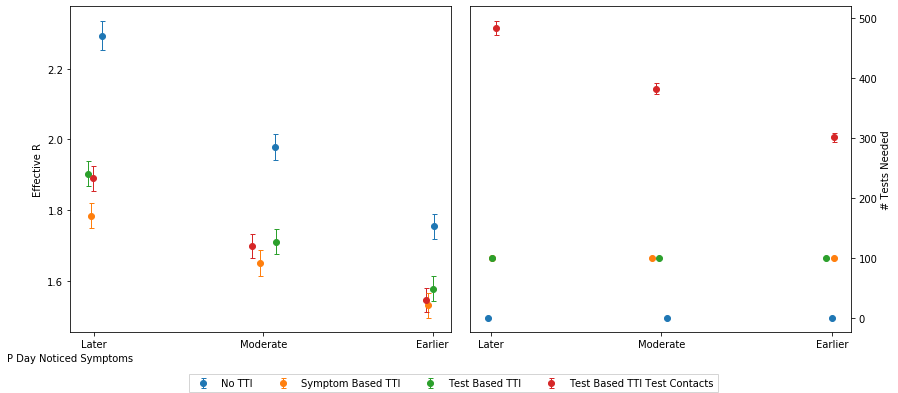

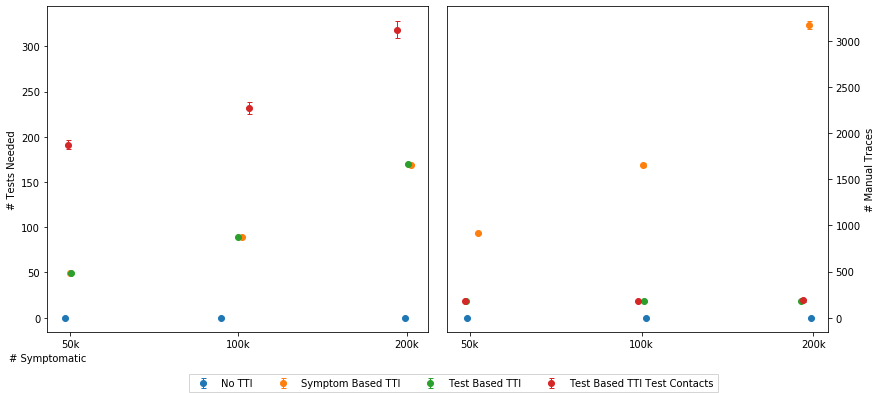

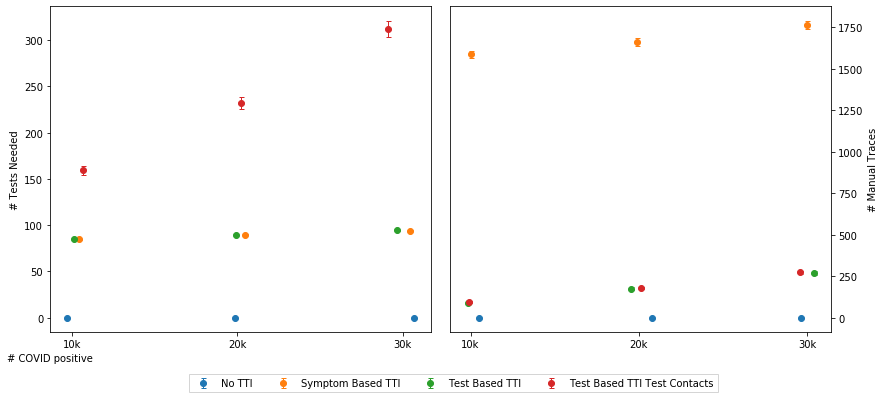

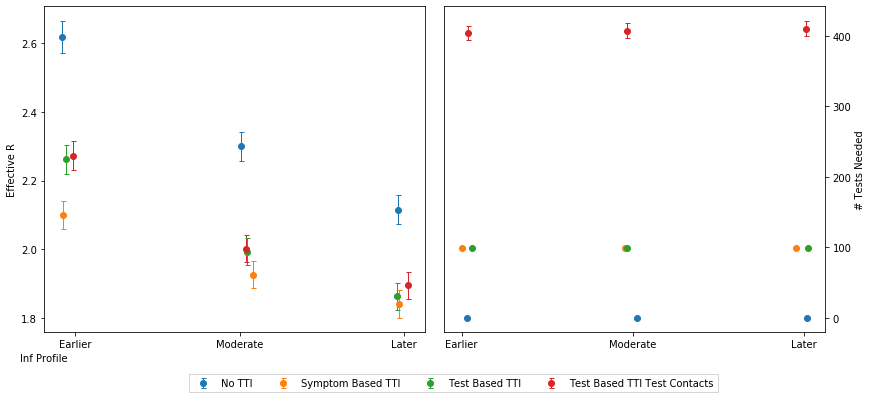

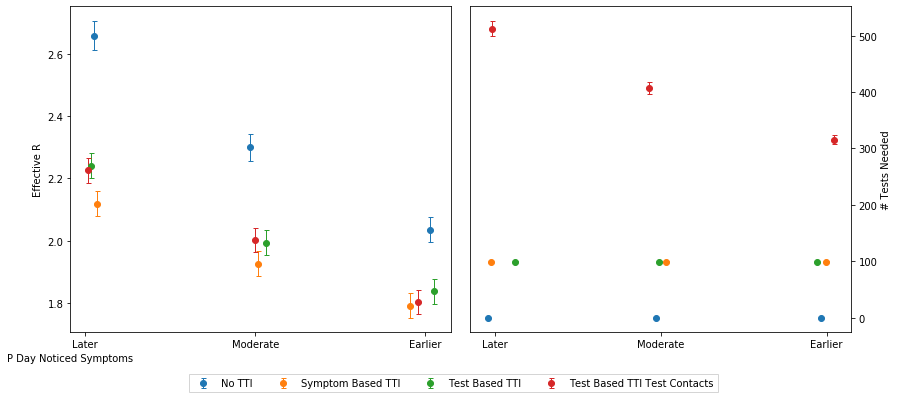

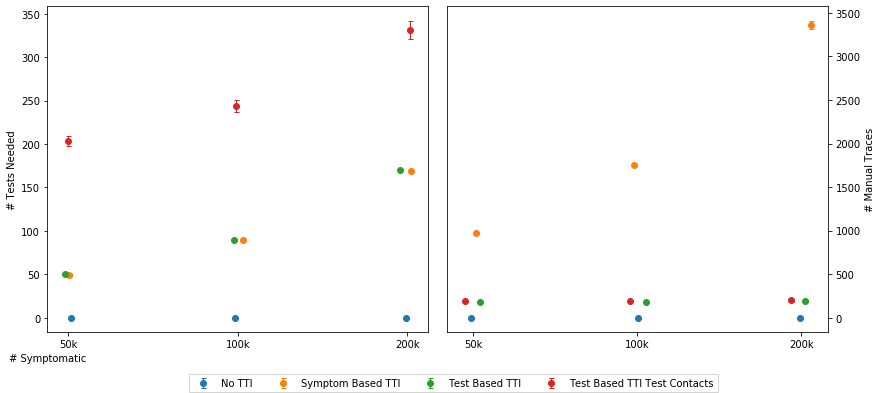

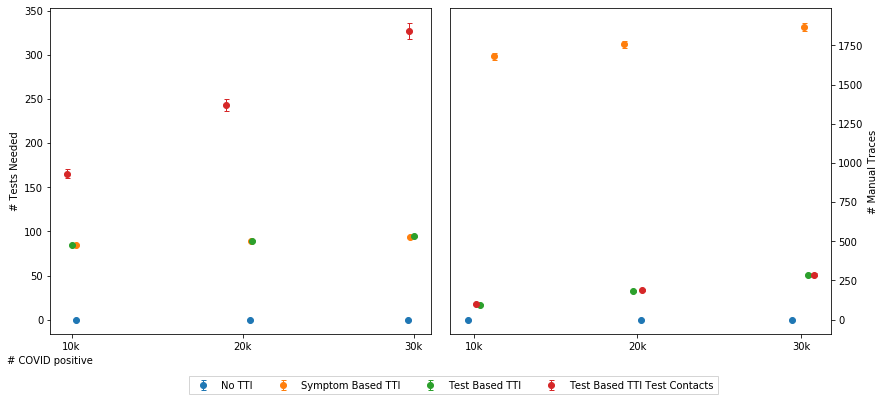

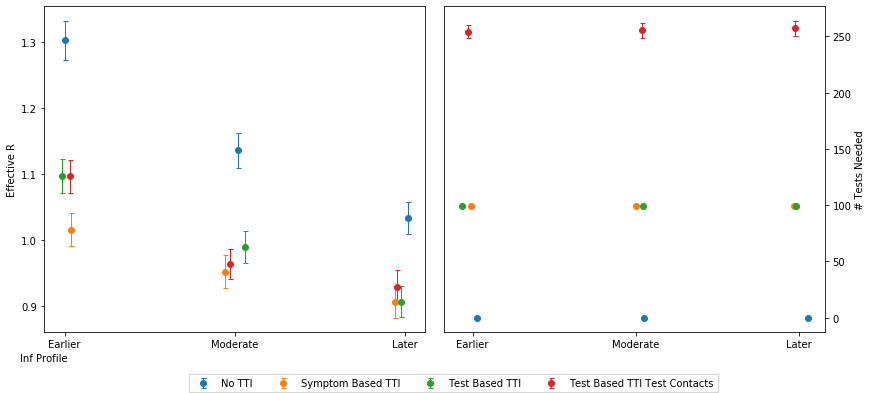

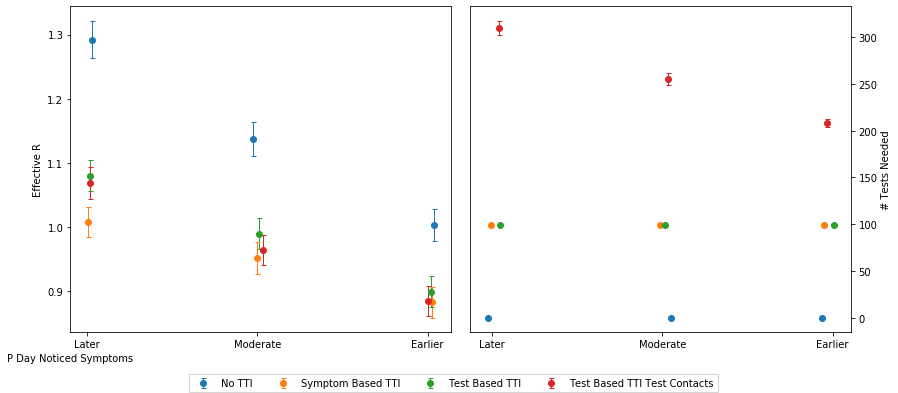

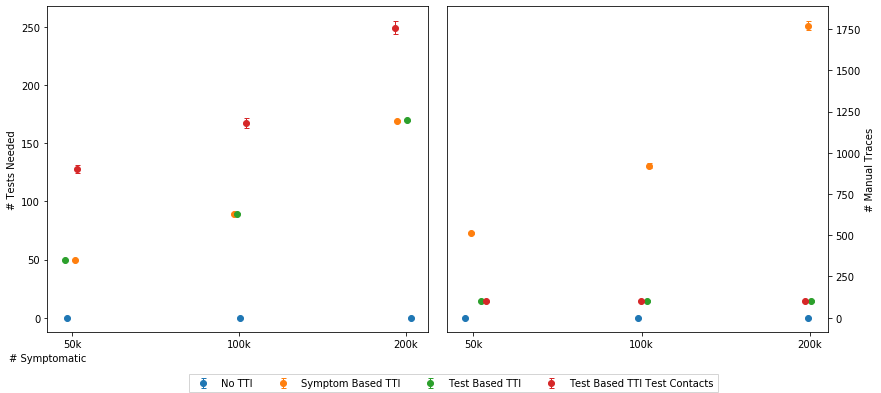

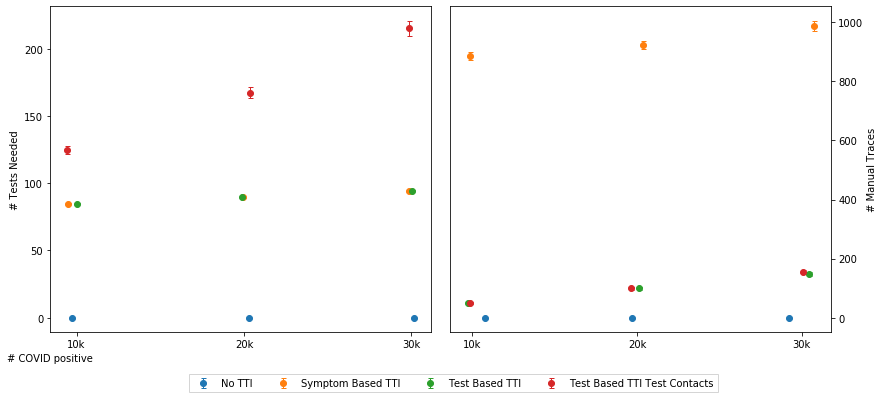

In [13]:
with plt.rc_context(rc_dct):
    plotter = LockdownSensitivityPlotter()
    for level, results in case_sensitivity_results.items():
        deck = utils.PdfDeck()
        plotter(results, deck, keys_to_plot)
        plot_infection_props(plotter, results, deck)
        deck.make(os.path.join(chart_folder, f"{level}_sensitivity.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)